<a href="https://colab.research.google.com/github/rpjayasekara/Fare-Classification-Problem/blob/master/fare_classification_refac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Import all the necessary dependecies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from collections import Counter
from geopy.distance import geodesic
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#read data
train = pd.read_csv('/content/drive/My Drive/train.csv') 
test = pd.read_csv('/content/drive/My Drive/test.csv')
com_data = [train, test] 
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [0]:
# Create a new feature fare time using the pick up and drop time
for data in com_data:
  data['pickup_time'] = pd.to_datetime(data['pickup_time'])
  data['drop_time'] = pd.to_datetime(data['drop_time'])
  data['fare_time'] = data['drop_time']-data['pickup_time']
  data['fare_time'] = data['fare_time'].dt.total_seconds()

In [0]:
# Create a new feature using pick up and drop up longitudes and latitudes
for data in com_data:
  geodesic((data['pick_lat'][0], data['pick_lon'][0]), (data['drop_lat'][0], data['drop_lon'][0])).meters
  for i, row in data.iterrows():
    data.at[i,'fare_distance'] = geodesic((data['pick_lat'][i], data['pick_lon'][i]), (data['drop_lat'][i], data['drop_lon'][i])).meters

In [6]:
labels = {"label": {"correct": 1, "incorrect": 0}}
train = train.replace(labels)
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance
0,189123628,10.5,834.0,56.0,0.0000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5072.064513
1,189125358,10.5,791.0,47.0,0.0000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3151.779729
2,189125719,10.5,1087.0,80.0,0.0000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6302.417567
3,189127273,10.5,598.0,271.0,15.6638,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,862.654437
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8148.520802


In [7]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000,17176.000000,17176.000000,1.717600e+04
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466,0.902131,1713.929902,4.845562e+03
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565,0.297146,8101.459112,4.295458e+04
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,0.000000,0.000000,0.000000e+00
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000,1.000000,540.000000,1.482193e+03
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000,1.000000,1020.000000,3.210817e+03
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000,1.000000,1800.000000,6.143571e+03
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,1.000000,453840.000000,5.601634e+06


In [0]:
new_train = (pd.get_dummies(train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_time', 'fare_distance', 'label']], dummy_na=True)).fillna(0)
new_test = (pd.get_dummies(test[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_time', 'fare_distance']], dummy_na=True)).fillna(0)

In [9]:
z = np.abs(stats.zscore(new_train))
print(np.where(z < 3.1))
train_cleaned = new_train[(z < 3.1).all(axis=1)]

(array([    0,     0,     0, ..., 17175, 17175, 17175]), array([0, 1, 2, ..., 6, 7, 8]))


In [10]:
train_cleaned.head()
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tripid                     17176 non-null  int64         
 1   additional_fare            16974 non-null  float64       
 2   duration                   16974 non-null  float64       
 3   meter_waiting              16974 non-null  float64       
 4   meter_waiting_fare         16974 non-null  float64       
 5   meter_waiting_till_pickup  16974 non-null  float64       
 6   pickup_time                17176 non-null  datetime64[ns]
 7   drop_time                  17176 non-null  datetime64[ns]
 8   pick_lat                   17176 non-null  float64       
 9   pick_lon                   17176 non-null  float64       
 10  drop_lat                   17176 non-null  float64       
 11  drop_lon                   17176 non-null  float64       
 12  fare

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
fare_time                      0
fare_distance                  0
dtype: int64

In [11]:
# Fill na values by mean
train_cleaned['additional_fare'].fillna(train_cleaned['additional_fare'].dropna().median(), inplace=True)
train_cleaned['duration'].fillna(train_cleaned['duration'].dropna().median(), inplace=True)
train_cleaned['meter_waiting'].fillna(train_cleaned['meter_waiting'].dropna().median(), inplace=True)
train_cleaned['meter_waiting_fare'].fillna(train_cleaned['meter_waiting_fare'].dropna().median(), inplace=True)
train_cleaned['meter_waiting_till_pickup'].fillna(train_cleaned['meter_waiting_till_pickup'].dropna().median(), inplace=True)
train_cleaned['fare'].fillna(train_cleaned['fare'].dropna().mean(), inplace=True)
train_cleaned.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,fare_time,fare_distance,label
0,10.5,834.0,56.0,0.0000,64.0,270.32,840.0,5072.064513,1
1,10.5,791.0,47.0,0.0000,134.0,197.85,780.0,3151.779729,1
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1080.0,6302.417567,1
3,10.5,598.0,271.0,15.6638,68.0,82.30,600.0,862.654437,1
4,0.0,0.0,0.0,0.0000,0.0,358.39,1020.0,8148.520802,1


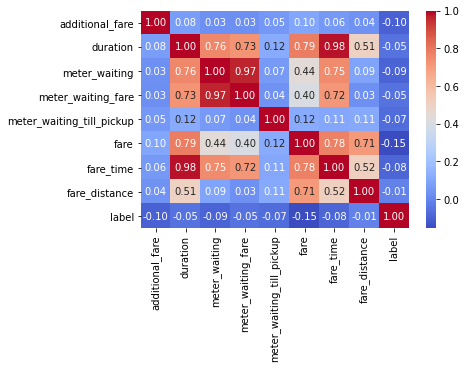

In [12]:
g = sns.heatmap(train_cleaned[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_time', 'fare_distance', 'label']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [0]:
x_train = (pd.get_dummies(train_cleaned[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_time', 'fare_distance']], dummy_na=True))
y_train = train_cleaned['label']

In [0]:
y = y_train.values
x = x_train.values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [15]:
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
acc_random_forest

94.79

In [0]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
RFC = RandomForestClassifier()

kfold = StratifiedKFold(n_splits=10)
## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,1000],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 38.0min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 38.4min finished


0.9535664676953111

In [0]:
test_x = new_test.values
Y_pred = RFC_best.predict(test_x)
submission = pd.DataFrame({
        "tripid": test["tripid"],
        "prediction": Y_pred
    })
submission.to_csv('/content/drive/My Drive/submission.csv', index=False)

In [0]:
import xgboost

model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=1000, n_jobs=6,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
from sklearn.model_selection import cross_val_score,KFold
score=cross_val_score(model, x_train, y_train, cv=10)
#print(score)
print("Mean cross validation score:%f"%score.mean())

kfold = KFold(n_splits=10)
kf_cv_scores = cross_val_score(model,x_train,y_train, cv=kfold)
print("K-fold CV average score: %f" % kf_cv_scores.mean())

Mean cross validation score:0.948617
K-fold CV average score: 0.949262


In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
train_X, val_X, train_y, val_y = train_test_split(x_train, y_train, random_state=1)
eval_set = [(train_X, train_y), (val_X, val_y)]
eval_metric = ['error','auc']
model.fit(train_X, train_y, eval_set=eval_set, eval_metric=eval_metric, verbose=True)


[0]	validation_0-error:0.053902	validation_0-auc:0.859638	validation_1-error:0.06562	validation_1-auc:0.849236
[1]	validation_0-error:0.05359	validation_0-auc:0.858432	validation_1-error:0.064917	validation_1-auc:0.85236
[2]	validation_0-error:0.05359	validation_0-auc:0.858223	validation_1-error:0.064917	validation_1-auc:0.852254
[3]	validation_0-error:0.053668	validation_0-auc:0.858564	validation_1-error:0.064682	validation_1-auc:0.852735
[4]	validation_0-error:0.053433	validation_0-auc:0.858526	validation_1-error:0.064682	validation_1-auc:0.85257
[5]	validation_0-error:0.053668	validation_0-auc:0.861485	validation_1-error:0.064682	validation_1-auc:0.853742
[6]	validation_0-error:0.053433	validation_0-auc:0.861772	validation_1-error:0.064448	validation_1-auc:0.853398
[7]	validation_0-error:0.053433	validation_0-auc:0.861895	validation_1-error:0.064214	validation_1-auc:0.854005
[8]	validation_0-error:0.053433	validation_0-auc:0.86202	validation_1-error:0.064214	validation_1-auc:0.85405

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=1000, n_jobs=6,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [36]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=1000, n_jobs=6,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
Y_pred = model.predict(new_test)
submission = pd.DataFrame({
        "tripid": test["tripid"],
        "prediction": Y_pred
    })
submission.to_csv('/content/drive/My Drive/submission_4.csv', index=False)